# Definities

In [2]:
# Basis
import numpy as np
import pandas as pd
from math import floor, sqrt
from statistics import mean
from glob import glob
import random
import warnings; warnings.filterwarnings('ignore')

# Geo
import geopandas as gp
from geopandas import GeoDataFrame, GeoSeries, sjoin
import shapely
from shapely import wkt
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
import shapely.speedups; shapely.speedups.enable()

# Plot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors
import matplotlib.animation as animation

Er worden verschillende coördinatenreferentiesystemen aangehouden in de gebruikte data. Er moeten ook berekeningen gedaan kunnen worden op de geometrieën (dit kan met cea en lambert). Tot slot kiezen we voor een Amersfoortprojectie voor de kaarten, maar Mercator levert ongeveer hetzelfde eindresultaat. 

In [3]:
# Definieer projecties
crs = {'init': 'epsg:4326'}          # Standaard WGS84
amersfoort = {'init': 'epsg:28992'}  # Rijkscoördinatendriehoek
cea = {'proj':'cea'}                 # Equal area
mercator = {'init': 'epsg:3395'}     # Mercatorprojectie
lambert = {'init': 'epsg:3035'}      # Lambert Azimuthal Equal Area projection

In [13]:
# Oppervlakte van een microbosje (4 bomen)
tiny_forest_area = 280  # m²

# Oppervlaktes van bomen (m²)
kleine_boom = 10.5
middel_boom = 14.3
grote_boom = 18.7

# Type bomen, gebaseerd op boomhoogte
lage_bomen = ['tot 6 m', '6-9 m', '9-12 m', 'Onbekend']
midd_bomen = ['12-15 m', '15-18 m']
hoge_bomen = ['18-24 m', '24 m en hoger']

Definieer een aantal functies die voor ons GeoDataFrames maken

In [5]:

def to_crs(gdf, crs_out=amersfoort):
    '''Returns a GeoDataFrame with coordinates projected as specified (default epsg:28992)'''
    gdf = gdf.to_crs(crs_out)  # Use geopandas built-in method
    gdf.crs = crs_out  # Set CRS property as well, just to be sure
    return gdf


def create_gdf(df, crs_in=crs, crs_out=amersfoort):
    '''Accepts a DataFrame with a specified CRS (default epsg:4326), 
    and returns a re-projected GeoDataFrame (default epsg:28992)'''
    
    # Transform Point geometries that are in the wrong format 
    if any(df.geometry.str.contains('POINT')):
        df['geometry'] = df.geometry.str.replace(',', ' ')
    
    # Transform geometry from text, create GeoDataFrame, and re-project to crs_out
    gdf = GeoDataFrame(df, crs=crs_in, geometry=df.geometry.apply(wkt.loads))
    return to_crs(gdf, crs_out)


def import_csv(csv, crs_in=crs, crs_out=amersfoort):
    '''Accepts a csv file and returns a GeoDataFrame'''
    df = pd.read_csv(csv, dtype=str, sep=';').drop(columns=['OBJECTNUMMER', 'WKT_LAT_LNG', 'LNG', 'LAT'])
    df = df[df.columns.drop(df.filter(regex='Unnamed').columns)].rename(columns={'WKT_LNG_LAT':'geometry'})
    return create_gdf(df, crs_in, crs_out)


def calc_area(gdf, m=False, crs_out=amersfoort):
    '''Adds a new column to a GeoDataFrame that contains the surface area in km² (or m² if m=True) of its geometries'''
    gdf = to_crs(gdf, cea)  # Use equal areas to make area calculations
    if not m:
        m = 10**6  # Re-calculate to km²
    gdf['oppervlakte'] = gdf.geometry.area / m
    return to_crs(gdf, crs_out)



# Gebieden

We importeren hier .csv-bestanden (epsg:4326) van de Gemeente Amsterdam (https://maps.amsterdam.nl/open_geodata/?LANG=nl).

In [6]:
# Importeer stadsdelen
sd = import_csv('data/020/GEBIED_STADSDELEN_EXWATER.csv')
sd = calc_area(sd)  # Voeg een kolom toe met oppervlakte per stadsdeel

# Importeer buurten
buurten = import_csv('data/020/GEBIED_BUURTEN_EXWATER.csv').rename(index=str, columns={'Buurt_code': 'Buurtcode'})
buurten = buurten[buurten.Buurtcombinatie_code != 'N73']  # We laten de buurt Waterland buiten beschouwing

# Bomen

We importeren hier .csv-bestanden (espg:4326) van de Gemeente Amsterdam (https://maps.amsterdam.nl/open_geodata/?k=254).

In [7]:
# Importeren en samenvoegen van de vier .csv-bestanden
bomen = pd.concat([pd.read_csv(file, sep=';', usecols=['Soortnaam_NL', 'Boomnummer', 'Boomtype', 'Boomhoogte', 'WKT_LNG_LAT']) 
                   for file in glob('data\BOMEN*.csv')], axis=0, ignore_index=True).rename(columns={'WKT_LNG_LAT':'geometry'})

# Elke boom heeft een aantal van 1, dit gebruiken we later
bomen['aantal_bomen'] = 1

# Kolom toevoegen met boomoppervlakte (in m²) op basis van de boomhoogte
bomen['boomoppervlakte'] = np.where(bomen['Boomhoogte'].isin(lage_bomen), kleine_boom, 
                                    np.where(bomen['Boomhoogte'].isin(hoge_bomen), grote_boom, middel_boom))

# Maak van bomen een fatsoenlijk GeoDataFrame
bomen = create_gdf(bomen)  # crs=amersfoort, zie functie hierboven

# Wegen

We importeren hier .GeoJson-bestanden (epsg:28992), die met behulp van QGIS zijn omgezet vanuit .gml-bestanden uit de BGT (https://www.pdok.nl/downloads/-/article/basisregistratie-grootschalige-topografie-bgt-). 

In [8]:
# Importeren van bermen
gdf_berm = gp.read_file('C:/Users/PSaalbrink/Desktop/BGT/GeoJSON/bgt_ondersteunendwegdeel AuxiliaryTrafficArea.GeoJSON')[[
    'gml_id', 'creationDate', 'function', 'surfaceMaterial', 'plus-fysiekVoorkomenOndersteunendWegdeel', 'geometry'
]].rename(columns={'plus-fysiekVoorkomenOndersteunendWegdeel':'fysiekVoorkomenWegdeel'})  # crs=amersfoort

In [9]:
# Importeren van wegen
gdf_weg = gp.read_file('C:/Users/PSaalbrink/Desktop/BGT/GeoJSON/bgt_wegdeel TrafficArea.GeoJSON')  # crs=amersfoort

# Kolommen ordenen 
gdf_weg = gdf_weg[[
    'gml_id', 'creationDate', 'function', 'surfaceMaterial', 'plus-fysiekVoorkomenWegdeel', 'plus-functieWegdeel', 'geometry'
]].rename(columns={'plus-fysiekVoorkomenWegdeel': 'fysiekVoorkomenWegdeel', 'plus-functieWegdeel': 'functieWegdeel'})

In [10]:
# Samenvoegen van bermen en wegen tot één dataset
gdf = GeoDataFrame(pd.concat([gdf_weg, gdf_berm], ignore_index=True), crs=amersfoort)
gdf = gdf.where(~gdf.isna(), 'waardeOnbekend')  # NaN vervangen door waardeOnbekend (is niet per se nodig)
gdf = gdf.set_index('gml_id')  # Indexeren op gml_id

# Kolom met oppervlakte per wegdeel toevoegen
gdf = calc_area(gdf, m=True)  # zie functie hierboven

# Waar op wegdelen staan bomen?

In [11]:
# We gaan hieronder een aantal kolommen toevoegen.
# Allereerst moeten we vinden welke bomen op welke wegdelen staan:
sjoined = sjoin(gdf, bomen, how='left')  # Deze bewaren we voor later


# Kolom toevoegen voor afstand van een boom tot de rand van een polygon.
# Hiervoor maken we een tijdelijk GeoDataFrame met daarin de bestaande bomen
tmp = to_crs(bomen.copy(), cea)  # Gebruik cea voor het rekenen met equal area

# Kopieër de geometrieën, zodat we zometeen de geometrie van bomen kunnen behouden naast de geometrie van wegdelen
tmp['punten'] = tmp.geometry.astype(str).copy()

# Maak opnieuw een spatial join, maar bewaar alleen de wegdelen waarop bomen staan
tmp = sjoin(to_crs(gdf.copy(), cea), tmp, how='inner')

# Maak een GeoSeries met de afstand van een boom-punt tot de rand van een wegdeel.
# We moeten hier opnieuw de geometrie inladen, omdat we deze hierboven hadden omgezet in tekst
tmp = tmp.geometry.exterior.distance(GeoDataFrame(tmp.punten, geometry=tmp.punten.apply(wkt.loads), crs=cea))
tmp.name = 'gem_afstand_tot_rand'
tmp = tmp.groupby(tmp.index).mean()  # Groepeer op gml_id van wegdeel, en neem het gemiddelde van gem_afstand_tot_rand

# Voeg gem_afstand_tot_rand toe aan de eerder gemaakte spatial join. Er wordt samengevoegd adhv gml_id van wegdeel
joined = sjoined.join(tmp, how='left')


# Kolom toevoegen aan ons GeoDataFrame voor het aantal bomen per wegdeel-polygoon
gdf = gdf.merge(joined  # Dit zijn de wegdelen plus de nieuwe kolom gem_afstand_tot_rand
                .groupby(joined.index).sum()[[  # Groepeer op gml_id van wegdeel, en neem de som van
                    'aantal_bomen', 'boomoppervlakte', 'gem_afstand_tot_rand']],  # deze kolommen
                how='left', left_index=True, right_index=True)  # Voeg samen op gml_id en behoud alle wegdelen

# Opschonen
del tmp, joined, sjoined

# Zet aantal_bomen om van float naar int
gdf['aantal_bomen'] = gdf.aantal_bomen.astype(int)

# Dit was eerst al een gemiddelde, maar omdat we hierboven aggregeerden met som, 
# moeten we opnieuw delen door het aantal om weer op het gemiddelde uit te komen
gdf['gem_afstand_tot_rand'] = gdf.gem_afstand_tot_rand / gdf.aantal_bomen

In [12]:
# Twee tabellen maken om te bekijken hoeveel bomen er op welke wegdelen staan
bomen_per_function = gdf[['function', 'aantal_bomen']].groupby(['function'], as_index=False).sum()
bomen_per_functieWegdeel = gdf[['functieWegdeel', 'aantal_bomen']].groupby(['functieWegdeel'], as_index=False).sum()

# Hoeveel bestaande bomen staan er niet op wegdelen? 
org = bomen.aantal_bomen.sum()
clc = gdf.aantal_bomen.sum()
print(f'Er zijn {org} - {clc} = {org - clc} bomen die niet op wegdelen staan,\n'
      f'deze worden in de verdere analyse dus buiten beschouwing gelaten.')
del org, clc

Er zijn 265036 - 138052 = 126984 bomen die niet op wegdelen staan,
deze worden in de verdere analyse dus buiten beschouwing gelaten.


# Ruimte vinden voor nieuwe bomen

In [14]:
# Kolommen toevoegen voor (ruimte voor) nieuwe bomen 

# Hiertoe wordt een tijdelijk GeoDataFrame aangemaakt
tmp = gdf[(gdf.aantal_bomen > 0) |  # op stukken waar al andere bomen staan
          ((gdf.aantal_bomen == 0) &  # op terrein waar nog geen bomen staan, en dat een van de volgende functies heeft:
           (gdf.function.isin(['transitie', 'voetpad', 'parkeervlak', 
                               'voetgangersgebied', 'woonerf', 'verkeerseiland', 'berm'])))]

# Beschikbare ruimte, gedefinieerd als het verschil tussen oppervlakte van een wegdeel en oppervlakte van bestaande bomen
tmp['ruimte'] = (tmp.oppervlakte - tmp.boomoppervlakte)
tmp.loc[tmp.ruimte < 0, 'ruimte'] = 0  # Beschikbare ruimte kan niet negatief zijn

# Aantal voor nieuwe bomen toevoegen, aan de hand van de beschikbare ruimte.
# Hierbij wordt ervan uitgegaan dat de beschikbare ruimte helemaal vol wordt geplant
# en dat een boom de ruimte inneemt van een vierde van een microbosje
tmp['nieuwe_bomen'] = (tmp.ruimte / (tiny_forest_area / 4)).astype(int)

# We kunnen ook uitrekenen welke grootte de bomen die we planten kunnen hebben
# Dit kan gebruikt worden voor een meer nauwkeurige berekening
tmp['grote_bomen']  = (tmp.ruimte / grote_boom).astype(int)
tmp['middel_bomen'] = np.where((tmp.ruimte % grote_boom) > middel_boom, 1, 0)
tmp['kleine_bomen'] = np.where(np.logical_and((tmp.ruimte % grote_boom) > kleine_boom, 
                                              (tmp.ruimte % grote_boom) < middel_boom), 1, 0)

# Tot slot de nieuwe kolommen toevoegen met ons GeoDataFrame
gdf = gdf.join(tmp[['ruimte', 'nieuwe_bomen', 'grote_bomen', 'middel_bomen', 'kleine_bomen']], how='left')

del tmp

In [15]:
# Hoeveel bomen kunnen we planten? 
groot = gdf.grote_bomen.sum().astype(int)
middel = gdf.middel_bomen.sum().astype(int)
klein = gdf.kleine_bomen.sum().astype(int)
print(f'Er kunnen {(gdf.nieuwe_bomen.sum() / 4).astype(int):,} microbosjes geplant worden in Amsterdam.\n'
      f'Deze kunnen bestaan uit {groot:,} grote, {middel:,} middel, en {klein:,} kleine bomen.')

Er kunnen 163,807 microbosjes geplant worden in Amsterdam.
Deze kunnen bestaan uit 2,744,480 grote, 56,190 middel, en 66,248 kleine bomen.


# Bomen planten

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

X = gdf[['Buurtcode', 'function', 'functieWegdeel', 'fysiekVoorkomenWegdeel', 'surfaceMaterial']].copy()
y = gdf['aantal_bomen'].copy()

enc = OneHotEncoder()
X = enc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

reg = LinearRegression()
reg.fit(X_train, y_train)

del result
result = pd.DataFrame(y_test)
result['predicted'] = reg.predict(X_test)
result['diff'] = result.aantal_bomen - result.predicted
result.sort_values(['aantal_bomen'], ascending=False)

aantal_bomen  predicted        diff
b90d42138-db05-11e7-951f-610a7ca84980           131   0.697535  130.302465
b90d42138-db05-11e7-951f-610a7ca84980           131   0.812018  130.187982
b90d42138-db05-11e7-951f-610a7ca84980           131   0.899441  130.100559
b90d42138-db05-11e7-951f-610a7ca84980           131   0.958497  130.041503
b90d42138-db05-11e7-951f-610a7ca84980           131   1.040829  129.959171
b07e4e2fb-e5ed-11e7-8ec4-89be260623ee            71   0.542547   70.457453
b22cffd47-e334-11e7-8ec4-89be260623ee            64   1.937873   62.062127
b22d04b69-e334-11e7-8ec4-89be260623ee            64   1.937873   62.062127
b89f8ca59-dc7f-11e7-951f-610a7ca84980            63   0.198627   62.801373
b8642cc2b-e5e7-11e7-8ec4-89be260623ee            57   2.698698   54.301302
bc7066b85-2f17-11e8-a5a2-73a1868acdce            56   1.132756   54.867244
be66ebc0a-2f17-11e8-a5a2-73a1868acdce            55   1.394757   53.605243
b3a60510d-8c90-11e8-a5a2-73a1868acdce            51   0.747573   50.252427
b3a60510e-8c90-11e8-a5a2-73a1868acdce            51   0.581844   50.418156
b3a60510d-8c90-11e8-a5a2-73a1868acdce            51   1.099316   49.900684
b3a60510d-8c90-11e8-a5a2-73a1868acdce            51   0.842992   50.157008
b3a60510d-8c90-11e8-a5a2-73a1868acdce            51   1.114415   49.885585
b7b287e93-d313-11e7-8ec4-89be260623ee            51  -0.227189   51.227189
b5191cfed-70b2-11e8-a5a2-73a1868acdce            48   0.755388   47.244612
b1de9b817-daed-11e7-8ec4-89be260623ee            47   2.158423   44.841577
bc5d8d2db-d3fc-11e7-951f-610a7ca84980            46   0.913098   45.086902
bf7f8e60d-d555-11e7-951f-610a7ca84980            43   0.889849   42.110151
ba4d28336-f523-11e8-a5a2-73a1868acdce            43   1.940698   41.059302
ba4d31f77-f523-11e8-a5a2-73a1868acdce            43   1.940698   41.059302
b538cd935-f523-11e8-a5a2-73a1868acdce            41   4.327140   36.672860
be9704c5d-768c-11e8-951f-610a7ca84980            41   1.627584   39.372416
be968d31a-768c-11e8-951f-610a7ca84980            41   8.002785   32.997215
b5b44ac31-daf1-11e7-8ec4-89be260623ee            41   1.837145   39.162855
b5b0a92fb-d26c-11e7-8ec4-89be260623ee            40   0.882965   39.117035
be9679a7d-768c-11e8-951f-610a7ca84980            40   4.327140   35.672860
...                                             ...        ...         ...
b1d4855b9-de4c-11e7-8ec4-89be260623ee             0   0.825147   -0.825147
b6dce37b4-d313-11e7-8ec4-89be260623ee             0   0.276505   -0.276505
b9596ef57-dfed-11e8-a5a2-73a1868acdce             0   0.014252   -0.014252
bda823ba8-541e-11e8-a5a2-73a1868acdce             0   0.079411   -0.079411
b52edc2aa-e092-11e7-8ec4-89be260623ee             0   0.647744   -0.647744
b2df7b716-daee-11e7-8ec4-89be260623ee             0   0.143104   -0.143104
b84f2e42e-d550-11e7-8ec4-89be260623ee             0  -0.144047    0.144047
b5ea943cc-d313-11e7-8ec4-89be260623ee             0   0.070831   -0.070831
b53f40698-dfb7-11e7-951f-610a7ca84980             0  -0.080768    0.080768
b9e4d8673-6e2b-11e8-a5a2-73a1868acdce             0   0.094587   -0.094587
b79ac0627-d556-11e7-8ec4-89be260623ee             0   0.670823   -0.670823
bf901f41a-e08b-11e7-951f-610a7ca84980             0   0.752413   -0.752413
b5a9451a0-d26c-11e7-8ec4-89be260623ee             0  -0.147753    0.147753
b25cebcb8-be10-11e8-80e2-b7dac308c237             0  -0.234218    0.234218
bbe7deda4-db06-11e7-8ec4-89be260623ee             0  -0.312535    0.312535
b64ce3aa2-d556-11e7-951f-610a7ca84980             0   0.278994   -0.278994
b9e49416e-6e2b-11e8-a5a2-73a1868acdce             0   0.693123   -0.693123
b27223fd2-e3d3-11e7-951f-610a7ca84980             0   0.739384   -0.739384
b1d93d251-d556-11e7-8ec4-89be260623ee             0   0.616918   -0.616918
b5e733d38-d550-11e7-951f-610a7ca84980             0   1.934331   -1.934331
b5f23a1a5-d550-11e7-951f-610a7ca84980             0   0.487666   -0.487666
b17035e97-d556-11e7-951f-610a7ca84980             0   0.057990  

In [16]:
# Eerst nog informatie over buurten toevoegen aan ons gdf, die kan worden gebruikt voor het plotten
gdf = sjoin(gdf, buurten[['geometry', 'Buurtcode', 'Buurt', 'Buurtcombinatie_code', 'Stadsdeel_code']], 
            how='left').drop(columns=['index_right'])
gdf = gdf[~gdf.Buurtcode.isna()]  # elke weg die buiten de buurten valt laten we weg

Definieer een aantal functies die voor ons willekeurig nieuwe bomen planten.

In [17]:

def random_points_within(poly, k, min_dist=.5):
    
    '''Returns a list of lists of k random Point objects that are within poly, seperated by at least min_dist'''
    
    min_x, min_y, max_x, max_y = poly.bounds
    points = []
    
    while len(points) < k:
        
        # Pak een random punt op de x-as, en vind en een random punt op de y-as dat in het polygoon ligt
        try:
            x = random.uniform(min_x, max_x)
            x_line = LineString([(x, min_y), (x, max_y)])
            x_line_intercept_min, x_line_intercept_max = x_line.intersection(poly).xy[1].tolist()
            y = random.uniform(x_line_intercept_min, x_line_intercept_max)
        except:
            continue
        
        point = Point([x, y])
        
        # Controleer of de afstand van een nieuwe boom tot bestaande bomen kleiner is dan min_dist
        # Dit werkt nog niet goed wanneer min_dist te groot is
        dist = []
        gdf = GeoDataFrame(points, crs=cea)
        for i in range(len(gdf)):
            dist.append(gdf.iat[i, 0].distance(point) < min_dist)
        
        # Voeg de nieuwe boom toe, behalve als er een andere boom dichterbij ligt dan min_dist
        if sum(dist) == 0:
            points.append(point)
        else:
            continue
        
    return points


def random_points(row):
    '''Returns a list of lists of random points, based on a geometry and a value of nieuwe_bomen in a GeoDataFrame'''
    return random_points_within(row['geometry'], row['nieuwe_bomen'])


def plant_trees(gdf):
    '''Returns a GeoSeries (with epsg:28992) of random points within each geometry of a GeoDataFrame'''
    gdf = to_crs(gdf, cea)  # change gdf.crs to cea for equal area calculations 
    points = gdf.apply(random_points, axis=1)  # get a list of lists of random points within gdf.geometry
    points = pd.Series(points).apply(lambda x: pd.Series(x)).stack().tolist()  # transform into a Series
    gdf = GeoSeries(points, crs=cea)  # transform into a GeoSeries
    gdf = to_crs(gdf, amersfoort)  # change crs to epsg:28992
    return gdf



Maak data om te plotten

In [18]:
# Maak subset van de wegen-data
tmp = gdf[gdf.Buurt.isin(['Alfa-driehoek', 'Bedrijventerrein Sloterdijk I'])]

# Maak een GeoSeries met nieuwe bomen
geo = plant_trees(tmp)

# Maak subset van bestaande bomen
boom = bomen[bomen.geometry.within(buurten[buurten.Buurt.isin(['Alfa-driehoek', 'Bedrijventerrein Sloterdijk I'])].geometry[0])]

# Pak de locatie van Matrixian
mx = GeoSeries(Point([118284, 489564]), crs=amersfoort)

# Waar planten we de bomen?

Maak een plot van de omgeving van Matrixian

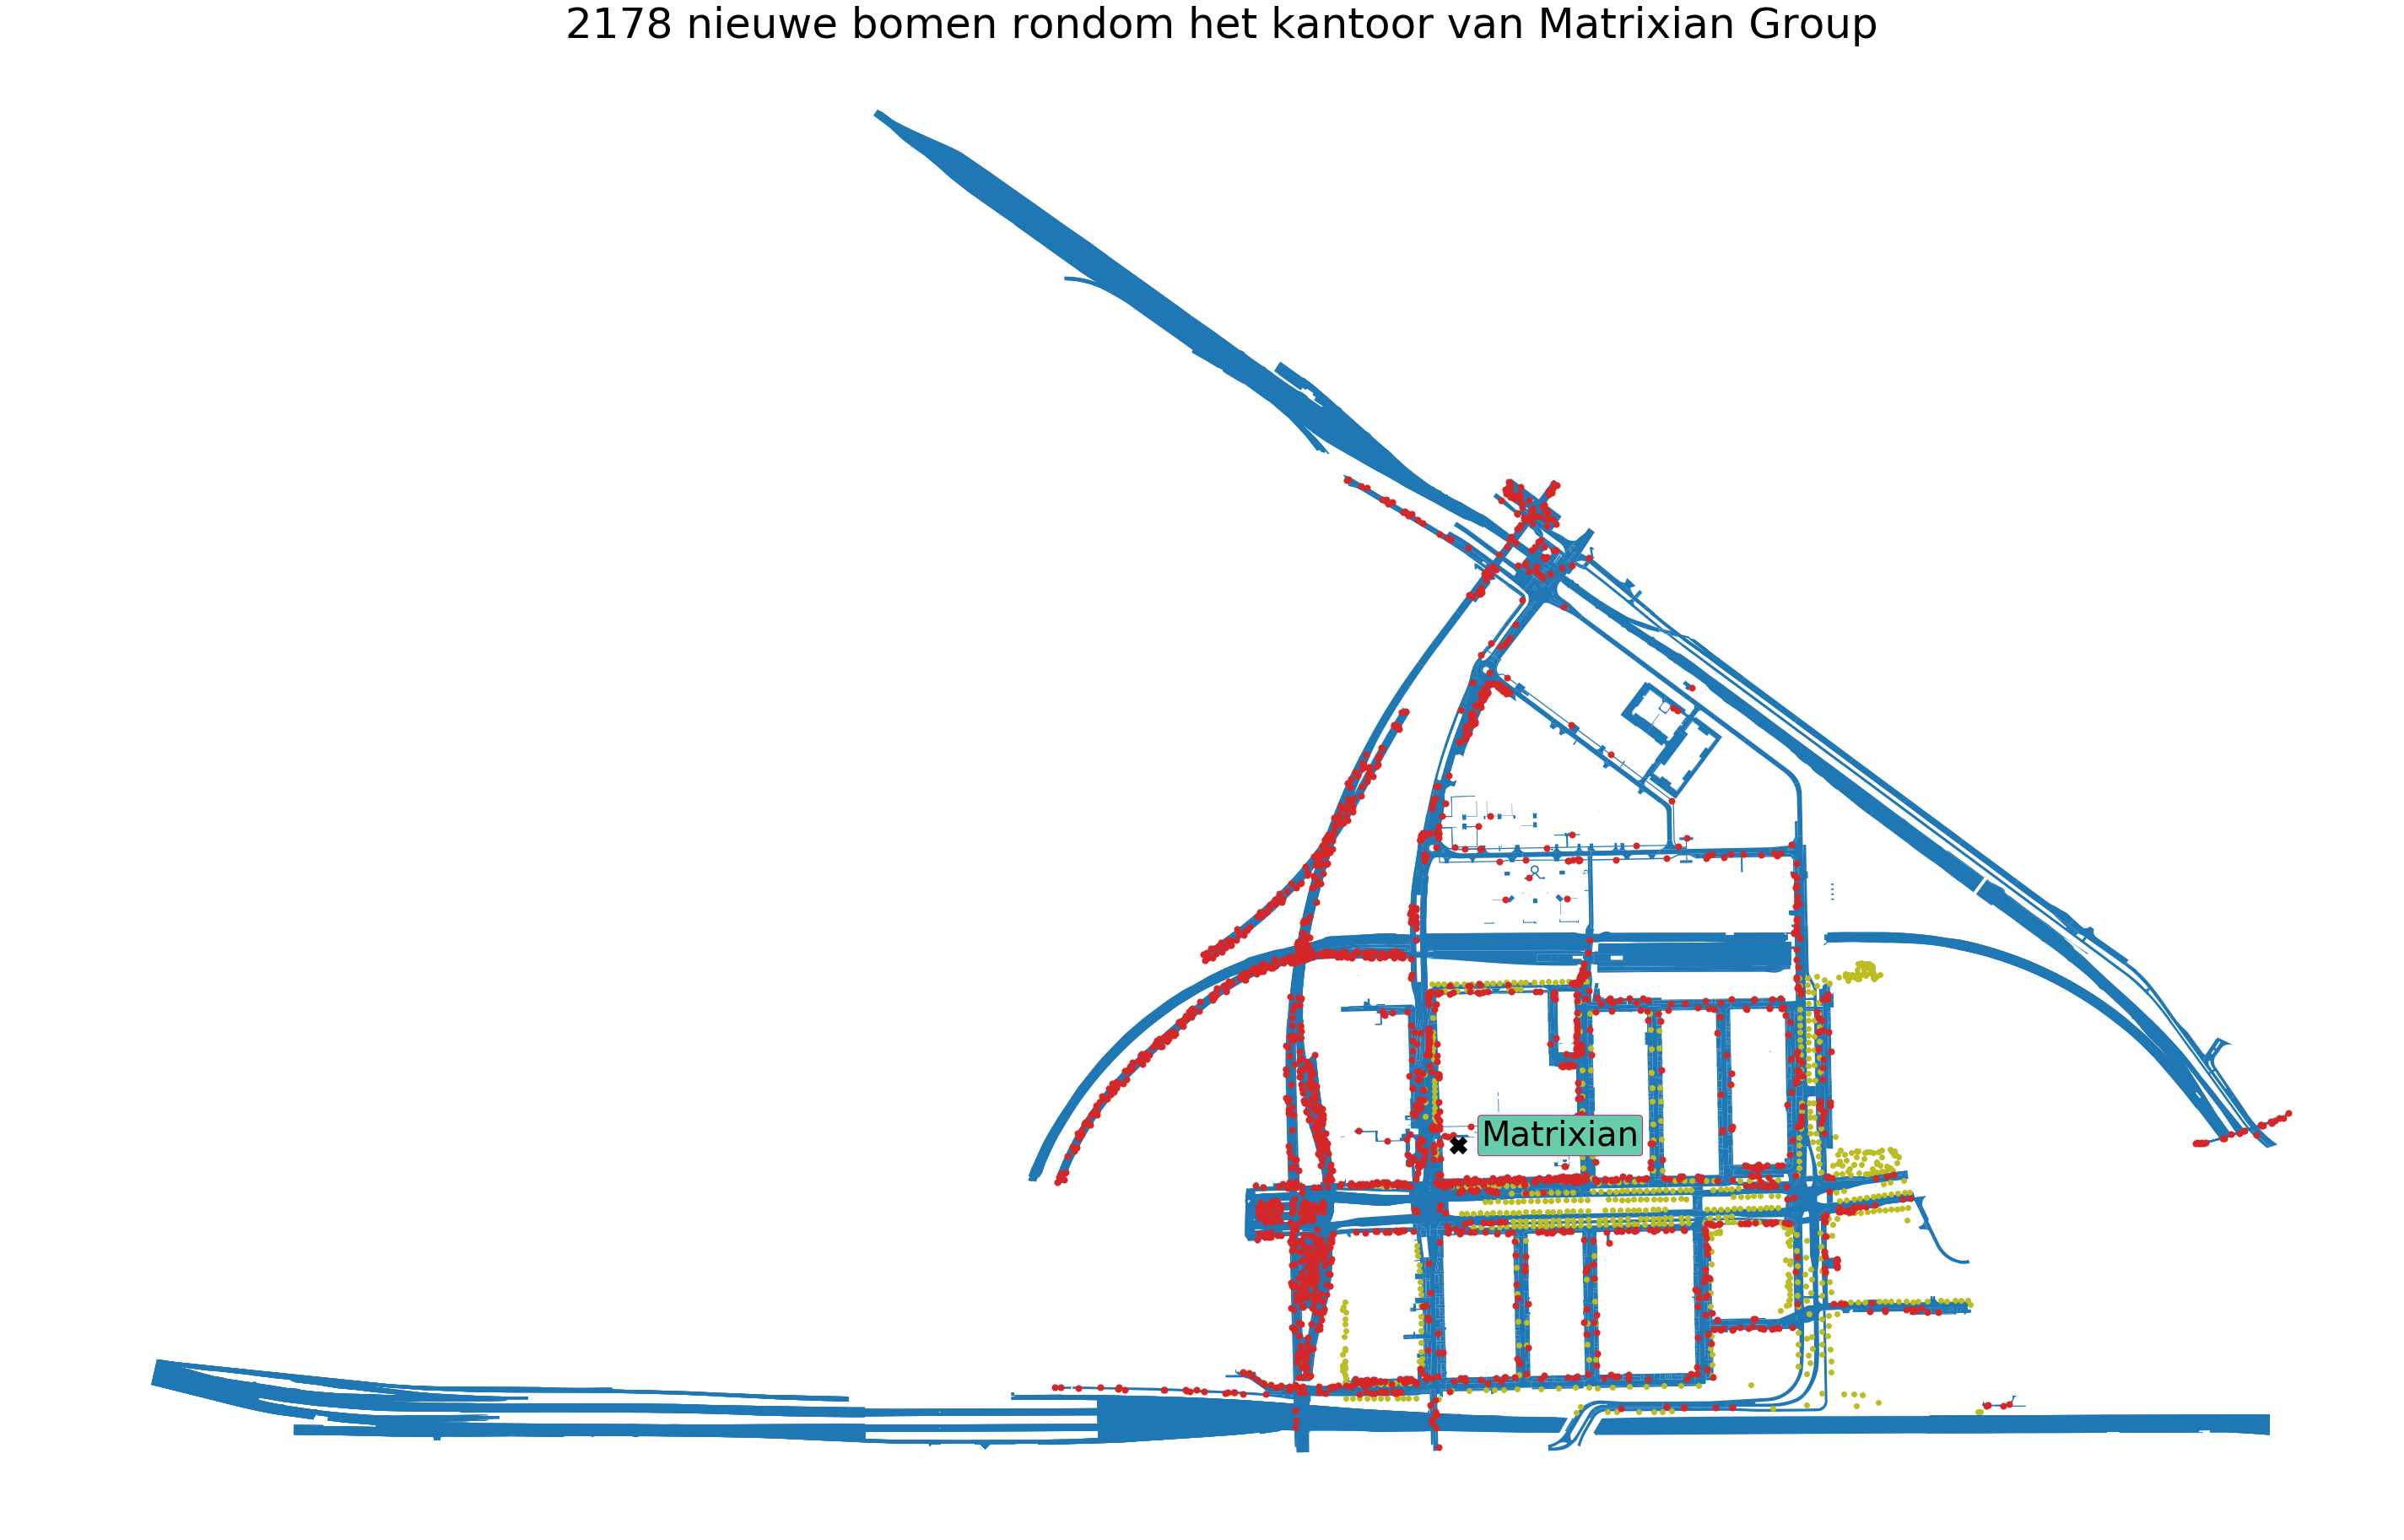

In [19]:
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
plt.title(f'{len(geo)} nieuwe bomen rondom het kantoor van Matrixian Group', size=50)

# Plot de wegen
tmp.plot(ax=ax, color='#1f77b4')

# Plot de bestaande bomen
boom.plot(ax=ax, color='#bcbd22')

# Plot de nieuwe bomen
geo.plot(ax=ax, color='#d62728', markersize=50)

# Plot de locatie van Matrixian
mx.plot(ax=ax, color='k', markersize=400, marker='X')
plt.annotate(s='Matrixian', xy=(118434, 489564), horizontalalignment='center', size=40, 
             bbox=dict(facecolor='mediumaquamarine', edgecolor='mediumvioletred', boxstyle=f'round,pad=0.1'));

# del geo, tmp

plt.savefig('MX.png')

Maak ook nog een plot voor stadsdeel Centrum (dit duurt eventjes)

In [18]:
geo_weg = GeoDataFrame(gdf.geometry.copy(), crs=amersfoort)
geo_weg = geo_weg[geo_weg.geometry.within(sd.geometry[0])]
geo_bomen = bomen[bomen.geometry.within(sd.geometry[0])]
nieuwe_bomen = plant_trees(gdf[gdf.geometry.within(sd.geometry[0])])

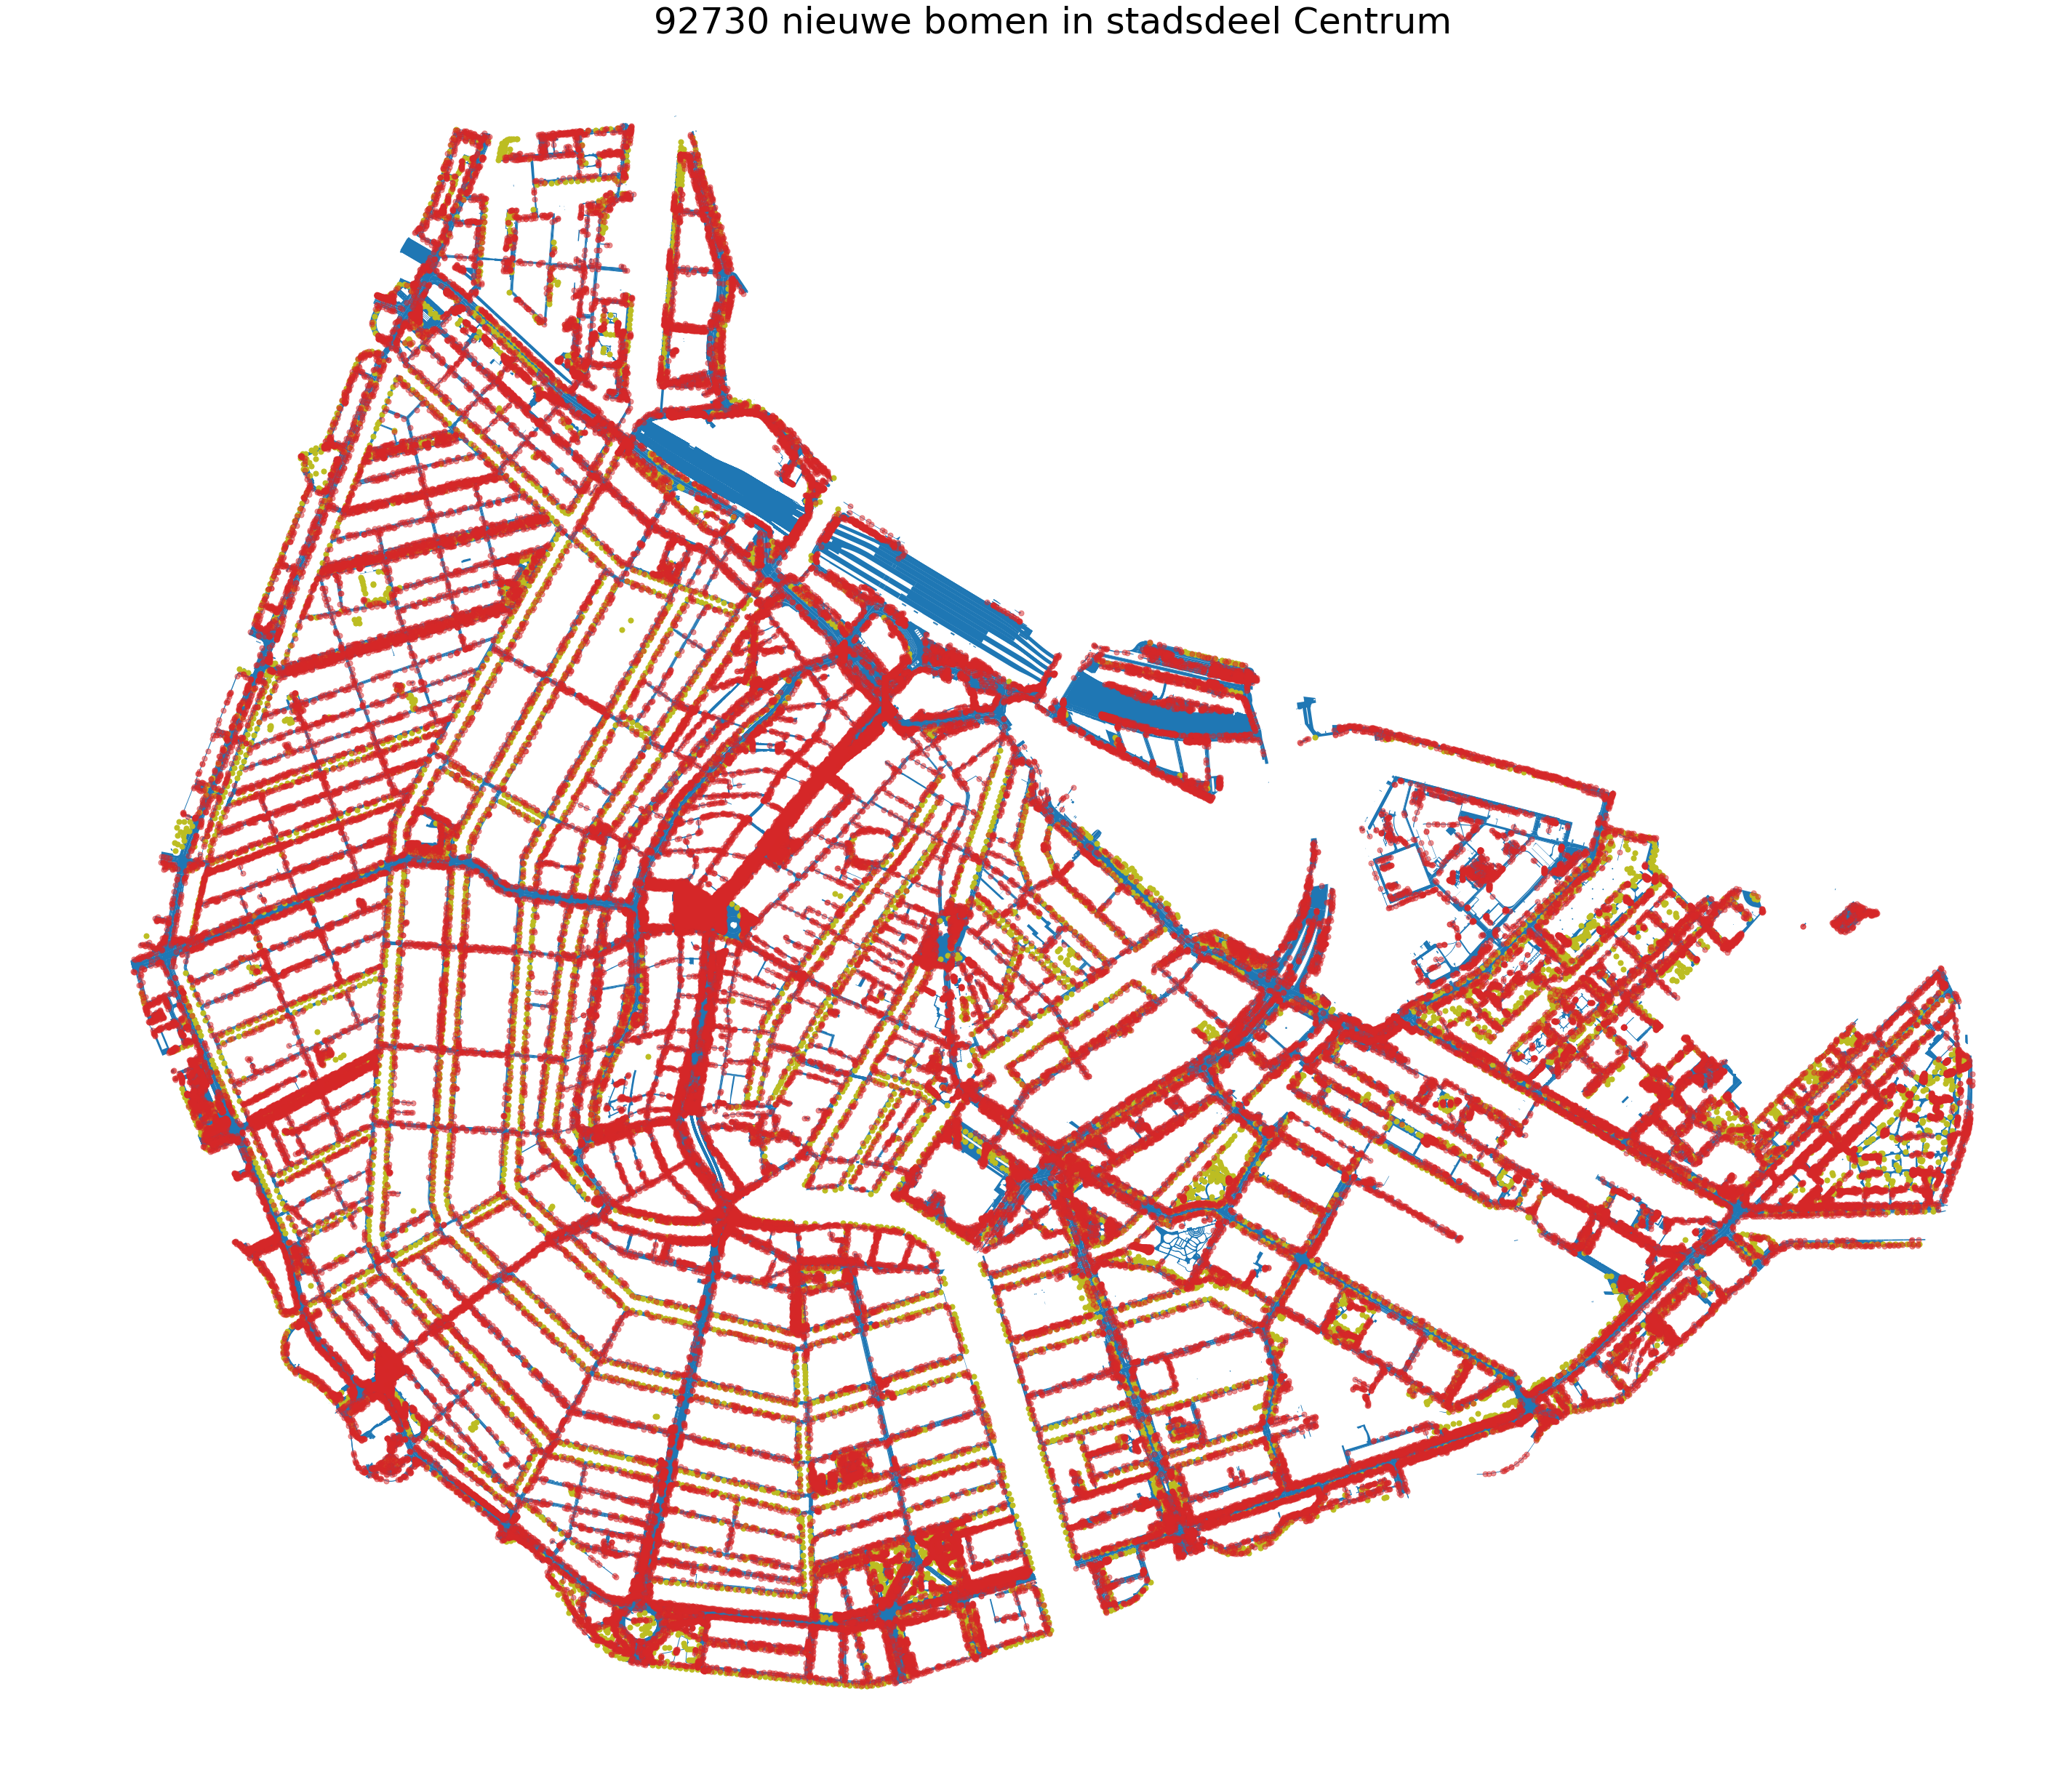

In [20]:
fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
plt.title(f'{len(nieuwe_bomen)} nieuwe bomen in stadsdeel Centrum', size=50)
geo_weg.plot(ax=ax, color='#1f77b4')
geo_bomen.plot(ax=ax, color='#bcbd22', markersize=50)
nieuwe_bomen.plot(ax=ax, color='#d62728', markersize=50, alpha=.5)
plt.savefig('Centrum_nwe_bomen.png')

# Vanaf hier is het louter geklooi.

Ik probeerde te onderzoeken hoe ik een plot kan maken waarbij de nieuwe bomen (met 257 tegelijk, in 34 iteraties) uit de grond zouden schieten 

In [ ]:
print(f'{int(len(geo)/34)} × {int(len(geo)/257)} = {len(geo)}')

In [ ]:
fig = plt.figure()
plt.scatter(geo.apply(lambda p: p.x), geo.apply(lambda p: p.y))
plt.axis('off');

In [ ]:
def main():
    x = geo.apply(lambda p: p.x)
    y = geo.apply(lambda p: p.y)
    data = np.array((x, y))
    
    fig = plt.figure()
    scat = plt.scatter(x, y)

    ani = animation.FuncAnimation(fig, update_plot, frames=257, fargs=(data, scat))
    plt.show()

def update_plot(i, data, scat):
    scat.set_array(data[i-257:i])
    return scat,

main()

In [ ]:
%matplotlib notebook

xdata = []
ydata = []

scat = plt.scatter(xdata, ydata)

def update(i):
    xdata.append(geo.apply(lambda p: p.x)[i-257:i])
    ydata.append(geo.apply(lambda p: p.y)[i-257:i])
    scat.set_array(np.array((xdata, ydata)))
    return scat

ani= matplotlib.animation.FuncAnimation(plt.gcf(), update, frames=257, interval=257, repeat=False)

plt.show()

In [ ]:
%matplotlib notebook 

fig = plt.figure()
plt.ion()  # enable interactivity
plt.axis('off')

x = list()
y = list()

for i in range(257, len(geo), 257):
    x.append(geo.apply(lambda p: p.x)[i-257:i])
    y.append(geo.apply(lambda p: p.y)[i-257:i])
    plt.scatter(x, y)
    plt.pause(.1)

In [ ]:
fig, ax = plt.subplots(1, figsize=(50, 50))
plt.axis('off')
gdf.plot(ax=ax, color='#1f77b4')
# bomen.plot(ax=ax, color='#bcbd22', markersize=50)
# geo = GeoSeries(gdf.points, crs=cea)
# geo.plot(ax=ax, color='#d62728', markersize=50);
# del geo

# Lengte en breedte

In deze code probeer ik de afmetingen van een polygon te benaderen (met de nadruk op benaderen)

In [ ]:
tmp = to_crs(gdf, cea)

item = 4
minx, miny, maxx, maxy = tmp.geometry[item].bounds

lengte1 = sqrt((maxx - minx)**2 + (maxy - miny)**2)
opp = tmp.geometry[item].area
breedte1 = opp / lengte1
print(f'{lengte1} x {breedte1} = {opp}')

lengte2 = maxx - minx
breedte2 = maxy - miny
ratio = opp / (lengte2*breedte2)
print(f'{lengte2*sqrt(ratio)} x {breedte2*sqrt(ratio)} = {opp}')

print(f'{mean((lengte1, lengte2))} x {mean((breedte1, breedte2))} = {opp}')

tmp.geometry[item]

del tmp